In [1]:
################################ Main text ############################################
import sys
sys.path.append('..')
from regression_utils import read_residual_data
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import glob
root = glob.glob('../data/trajectories/*')

In [3]:
horizon = 5

In [4]:
## Dataset preparation
x, xref, xH, xHref, error, errorH = read_residual_data(root, horizon)

In [11]:
error.shape

(220497, 7)

In [5]:
x.shape

(220497, 21)

In [13]:
errorH.shape

(220437, 7)

In [14]:
xH.shape

(220437, 105)

In [15]:
xHref.shape

(220437, 105)

### Sample data

In [16]:
import random

picked_point = np.random.choice(list(range(len(x))), 1000)
x_sample = x[picked_point]
error_sample = error[picked_point]

### Training

Ridge regression

In [17]:
from regression import CV_RR
from sklearn.preprocessing import PolynomialFeatures

def feature1(X):
    aug = X
    poly = PolynomialFeatures(1)
    X = poly.fit_transform(aug)
    return X

100%|██████████| 10/10 [00:00<00:00, 11.08it/s]


Min MSE:  1.9225174227500872


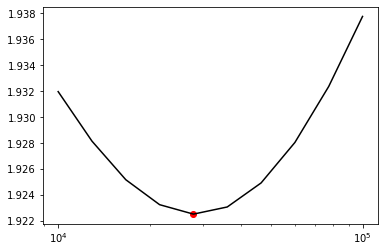

In [18]:
labd = np.logspace(4, 5, 10)
RR = CV_RR(labd)
RR.fit(feature1(x), error, 4)

gaussian process

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

gp_kernel = kernel = 0.1 * RBF(1)
gpr = GaussianProcessRegressor(kernel=gp_kernel, alpha=.5).fit(x_sample, error_sample)
gpr.score(x_sample, error_sample)

0.25394524640624866

##  Res predictor

100%|██████████| 10/10 [00:00<00:00, 11.20it/s]


Min MSE:  1.7636842625880005


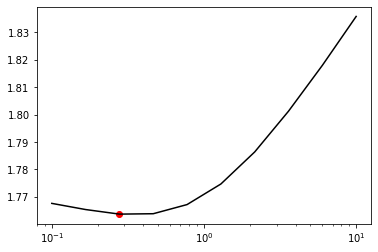

In [20]:
labd = np.logspace(-1, 1, 10)
RR_res = CV_RR(labd)
RR_res.fit(feature1(x-xref), error, 4)

## Res tracking error horizon predictor

100%|██████████| 5/5 [00:01<00:00,  3.25it/s]


Min MSE:  1.754953683386836


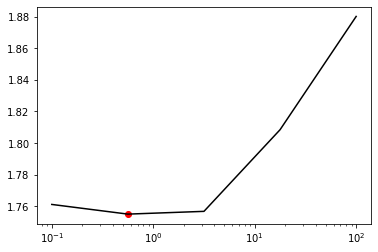

In [21]:
labd = np.logspace(-1,2,5)
RR_resH = CV_RR(labd)
RR_resH.fit(feature1(xH - xHref), errorH, 4)

## Res hand feature

In [22]:
def feature2(X):
    aug = X
    poly = PolynomialFeatures(1)
    aug = poly.fit_transform(aug)
    for k in range(9):
        aug = np.concatenate([aug, np.cos(k*X)], axis=1)
        aug = np.concatenate([aug, np.sin(k*X)], axis=1)
    return aug

100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


Min MSE:  1.7863220615827355


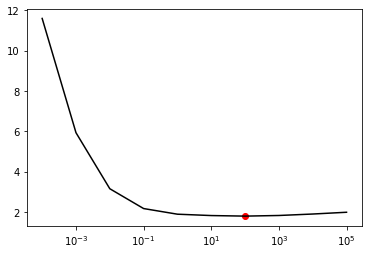

In [23]:
labd = np.logspace(-4, 5, 10)
RR_res_NL = CV_RR(labd)
RR_res_NL.fit(feature2(x-xref), error, 4)

# test trajectory

In [24]:
# import a new trajectory
path = ['../data/test_trajectory/traj17_z.panda.dat']

x_test, xref_test, xH_test, xHref_test, errror_test, errorH_test = read_residual_data(path, horizon)

In [25]:
x_test.shape

(23051, 21)

In [26]:
res_pred_RR = RR.predict(feature1(x_test), RR.beta)

In [27]:
res_pred_RR_res = RR_res.predict(feature1(x_test-xref_test), RR_res.beta)

In [28]:
res_pred_RR_resNL = RR_res_NL.predict(feature2(x_test-xref_test), RR_res_NL.beta)

In [29]:
res_pred_RR_resH = RR_resH.predict(feature1(xH_test-xHref_test), RR_resH.beta)

In [30]:
res_pred_GP = gpr.predict(x_test)

Sigmoidal model

In [31]:
## original paper proposed method
from Common.utils import *
from regression_utils import read_traj

time, q_real, qDot_real, qDot_real_filtered, qDDot_inf, tau_real, tau_real_filtered, tau_MCG\
                                                                                        = read_traj(path[0])

parameter_x = np.load('../Common/residual_dynamics.npy')
_, _, res_sig = stack_regressor(time, q_real, qDot_real_filtered, \
                qDDot_inf, tau_real_filtered, calc_friction_tau=True, opt_x=parameter_x)

The stacked regressor has 43 rank and it's condition number is 43.14410020293676.


In [38]:
MAE = ((errror_test - res_pred_RR)**2).sum() / len(errror_test)
print("Mean square error [RR]: {:.2f}".format(MAE))
MAE = ((errror_test - res_pred_RR_res)**2).sum() / len(errror_test)
print("Mean square error [RR_res]: {:.2f}".format(MAE))
MAE = ((errror_test[horizon:,:] - res_pred_RR_resH)**2).sum() / len(errror_test[horizon:,:])
print("Mean square error [RR_resH]: {:.2f}".format(MAE))
MAE = ((errror_test - res_pred_RR_resNL)**2).sum() / len(errror_test)
print("Mean square error [RR_resNL]: {:.2f}".format(MAE))
MAE = ((errror_test - res_sig)**2).sum() / len(errror_test)
print("Mean square error [sig]: {:.2f}".format(MAE))
MAE = ((errror_test)**2).sum() / len(errror_test)
print("Mean square error [No]: {:.2f}".format(MAE))
MAE = ((errror_test - res_pred_GP)**2).sum() / len(errror_test)
print("Mean square error [GP]: {:.2f}".format(MAE))

Mean square error [RR]: 3.42
Mean square error [RR_res]: 2.90
Mean square error [RR_resH]: 2.84
Mean square error [RR_resNL]: 3.03
Mean square error [sig]: 3.44
Mean square error [No]: 3.65
Mean square error [GP]: 3.43


## Plotting

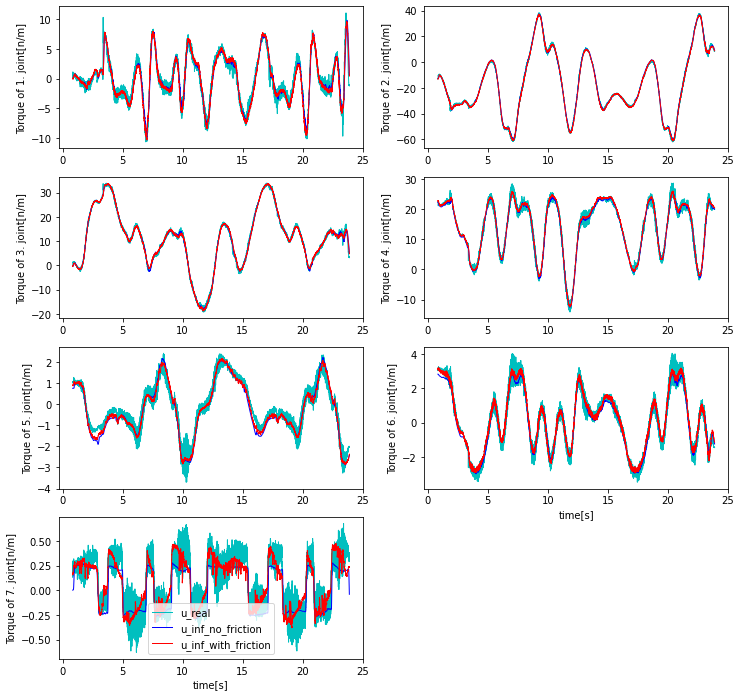

In [33]:
plot_test_results_with_friction(time, tau_real, tau_MCG+res_sig, tau_MCG+res_pred_RR_res)

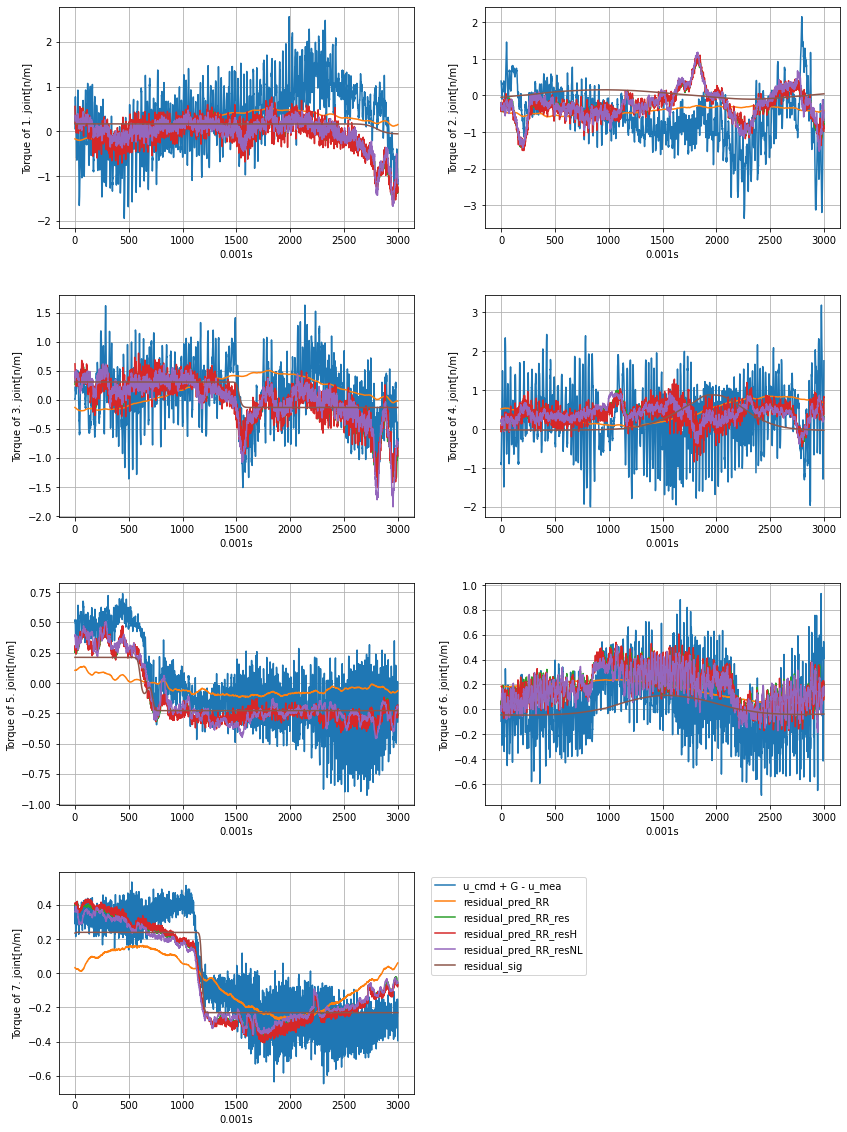

In [35]:
plt.figure(figsize=[14,20])
for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="0.001s", ylabel="Torque of {}. joint[n/m]".format(channel+1))
    plt.grid()
    plt.plot(errror_test[3000:3000+3000,channel], label='u_cmd + G - u_mea')
    plt.plot(res_pred_RR[3000:3000+3000,channel], label='residual_pred_RR')
    plt.plot(res_pred_RR_res[3000:3000+3000,channel], label='residual_pred_RR_res')
    plt.plot(res_pred_RR_resH[3000:3000+3000,channel], label='residual_pred_RR_resH')
    plt.plot(res_pred_RR_resNL[3000:3000+3000,channel], label='residual_pred_RR_resNL')
    plt.plot(res_sig[3000:3000+3000,channel], label='residual_sig')
#     plt.plot(res_pred_GP[:,channel], '-c', label='residual_pred_GP')
#     plt.plot(res_pred[:,channel] + var_pred, '-.r', linewidth=0.3, label='variance')
#     plt.plot(res_pred[:,channel] - var_pred, '-.r', linewidth=0.3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)    
plt.legend(bbox_to_anchor=(1.5, 1),fancybox=True)

plt.savefig('/home/jiayun/Desktop/residual.jpg', dpi=200)
plt.show()